In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from skimage import color, morphology, filters


# measurement parameters
# quad name in bmad QM10651, PV QUAD:IN10:651:BCTRL
# quad length 1.08e-1 m
# quad location 16.414943 m

# screen PV PROF:LI11:375
# PR11375[alias]=OTRS:LI11:375
# location 50.553112


folder = "D:/SLAC/FACET-II/emittance_scan/images/PR11375/"

## Image processing

In [2]:
raw_images = []
for i in range(1, 11):
    for j in range(5):
        fname = folder + f"PR11375_data_step{i:0>2}_{j:0>4}.tif"
        im = Image.open(fname)
        raw_images += [np.array(im)[600:800, 400:600]]


# apply filters to images
def apply_filter(image):
    return filters.median(image, morphology.disk(2))

thresh = filters.threshold_triangle(apply_filter(raw_images[-1]))

max_val = np.max(np.array(raw_images))

images = []
for im in raw_images:
    # apply median filter
    im = apply_filter(im)

    im = np.where(im > thresh, im, 0)
    images += [im]

images = np.array(images)

# create meshgrid for images
xx = np.meshgrid(
    np.arange(images[0].shape[0]),
    np.arange(images[0].shape[1]),
)

plt.figure()

# find centroid and rms size of images to center and crop
cx = np.average(xx[0], weights=images.sum(axis=0))
cy = np.average(xx[1], weights=images.sum(axis=0))
std_x = np.sqrt(np.average((xx[0] - cx)**2, weights=images.sum(axis=0)))
std_y = np.sqrt(np.average((xx[1] - cy)**2, weights=images.sum(axis=0)))
print(std_x, std_y)

cx = int(cx)
cy = int(cy)

# crop pixels
std = int(max(std_y,std_x))
margin = 3
bounds_x = slice(*[cx - margin*std, cx + margin*std])
bounds_y = slice(*[cy - margin*std, cy + margin*std])
xx[0] = xx[0][bounds_x, bounds_y] - cx
xx[1] = xx[1][bounds_x, bounds_y] - cy
images = images[:, bounds_x, bounds_y]

# pixel scaling
xx = np.asfarray(xx) * 8.97*1e-6
xx = xx * 10.0

#for im in images:
#    fig,ax = plt.subplots()
#    ax.pcolor(*xx, im, vmax=max_val)
#    ax.set_aspect("equal")




22.278849657359288 13.021215495380213


<Figure size 432x288 with 0 Axes>

## reconstruction analysis

In [3]:
import torch
# convert image data to tensors
tkwargs = {"device":"cuda", "dtype": torch.float32}
xxt = torch.tensor(xx, **tkwargs)

# scale images such that the sum is 1
timages = torch.tensor(np.array(images, dtype=int), **tkwargs)
timages = timages / timages.sum(dim=-1).sum(dim=-1).unsqueeze(1).unsqueeze(1)
# define a unit multivariate normal
from torch.distributions import MultivariateNormal

normal_dist = MultivariateNormal(torch.zeros(6), torch.eye(6))
normal_samples = normal_dist.sample([10000]).to(**tkwargs)

# define nonparametric transform
from normalizing_flow import NonparametricTransform, image_difference_loss

tnf = NonparametricTransform()
tnf.to(tkwargs["device"])

defaults = {
    "s": torch.tensor(0.0, **tkwargs),
    "p0c": torch.tensor(1.0, **tkwargs),
    "mc2": torch.tensor(1.0, **tkwargs),
}

k_in = torch.linspace(-10, 20, 10, **tkwargs)
k_in = torch.vstack([k_in.unsqueeze(0) for _ in range(5)]).T.flatten().unsqueeze(1)
bins = xxt[0][0]
bandwidth = torch.tensor(5e-4, **tkwargs)

from track import Particle, Quadrupole, Drift, Lattice
quad = Quadrupole(torch.tensor(0.1, **tkwargs), K1=k_in)
drift = Drift(L=torch.tensor(1.0, **tkwargs))
lattice = Lattice([quad, drift], torch)

In [4]:
import time
optim = torch.optim.Adam(tnf.parameters(), lr=0.001)
n_iter = 2000
losses = []

start = time.time()
for i in range(n_iter):
    optim.zero_grad(set_to_none=True)
    guess_dist = Particle(*tnf(normal_samples).T, **defaults)

    loss = image_difference_loss(
        guess_dist, timages, lattice, bins=bins, bandwidth=bandwidth
    )
    losses += [loss.cpu().detach()]
    loss.backward()

    optim.step()
finish = time.time()

print(f"total time: {finish - start}")
print(f"{(finish - start) / n_iter} s per step")


total time: 120.45316410064697
0.06022658205032349 s per step


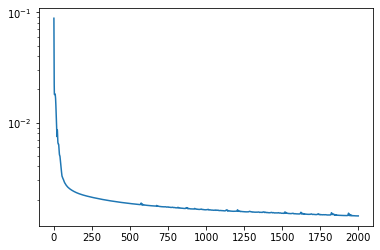

In [5]:
fig, ax = plt.subplots()
ax.semilogy(losses)

tensor(0.0018)
tensor(0.0025)
tensor(0.0018)
tensor(0.0025)
tensor(0.0018)
tensor(0.0024)
tensor(0.0018)
tensor(0.0023)
tensor(0.0018)
tensor(0.0026)
tensor(0.0020)
tensor(0.0026)
tensor(0.0020)
tensor(0.0026)
tensor(0.0020)
tensor(0.0027)
tensor(0.0020)
tensor(0.0027)
tensor(0.0020)
tensor(0.0026)
tensor(0.0022)
tensor(0.0027)
tensor(0.0022)
tensor(0.0028)
tensor(0.0022)
tensor(0.0028)
tensor(0.0022)
tensor(0.0028)
tensor(0.0022)
tensor(0.0028)
tensor(0.0016)
tensor(0.0020)
tensor(0.0016)
tensor(0.0021)
tensor(0.0016)
tensor(0.0022)
tensor(0.0016)
tensor(0.0020)
tensor(0.0016)
tensor(0.0019)
tensor(0.0010)
tensor(0.0008)
tensor(0.0010)
tensor(0.0008)
tensor(0.0010)
tensor(0.0008)
tensor(0.0010)
tensor(0.0008)
tensor(0.0010)
tensor(0.0008)
tensor(0.0008)
tensor(0.0006)
tensor(0.0008)
tensor(0.0006)
tensor(0.0008)
tensor(0.0006)
tensor(0.0008)
tensor(0.0006)
tensor(0.0008)
tensor(0.0005)
tensor(0.0006)
tensor(0.0007)
tensor(0.0006)
tensor(0.0007)
tensor(0.0006)
tensor(0.0007)
tensor(0.0

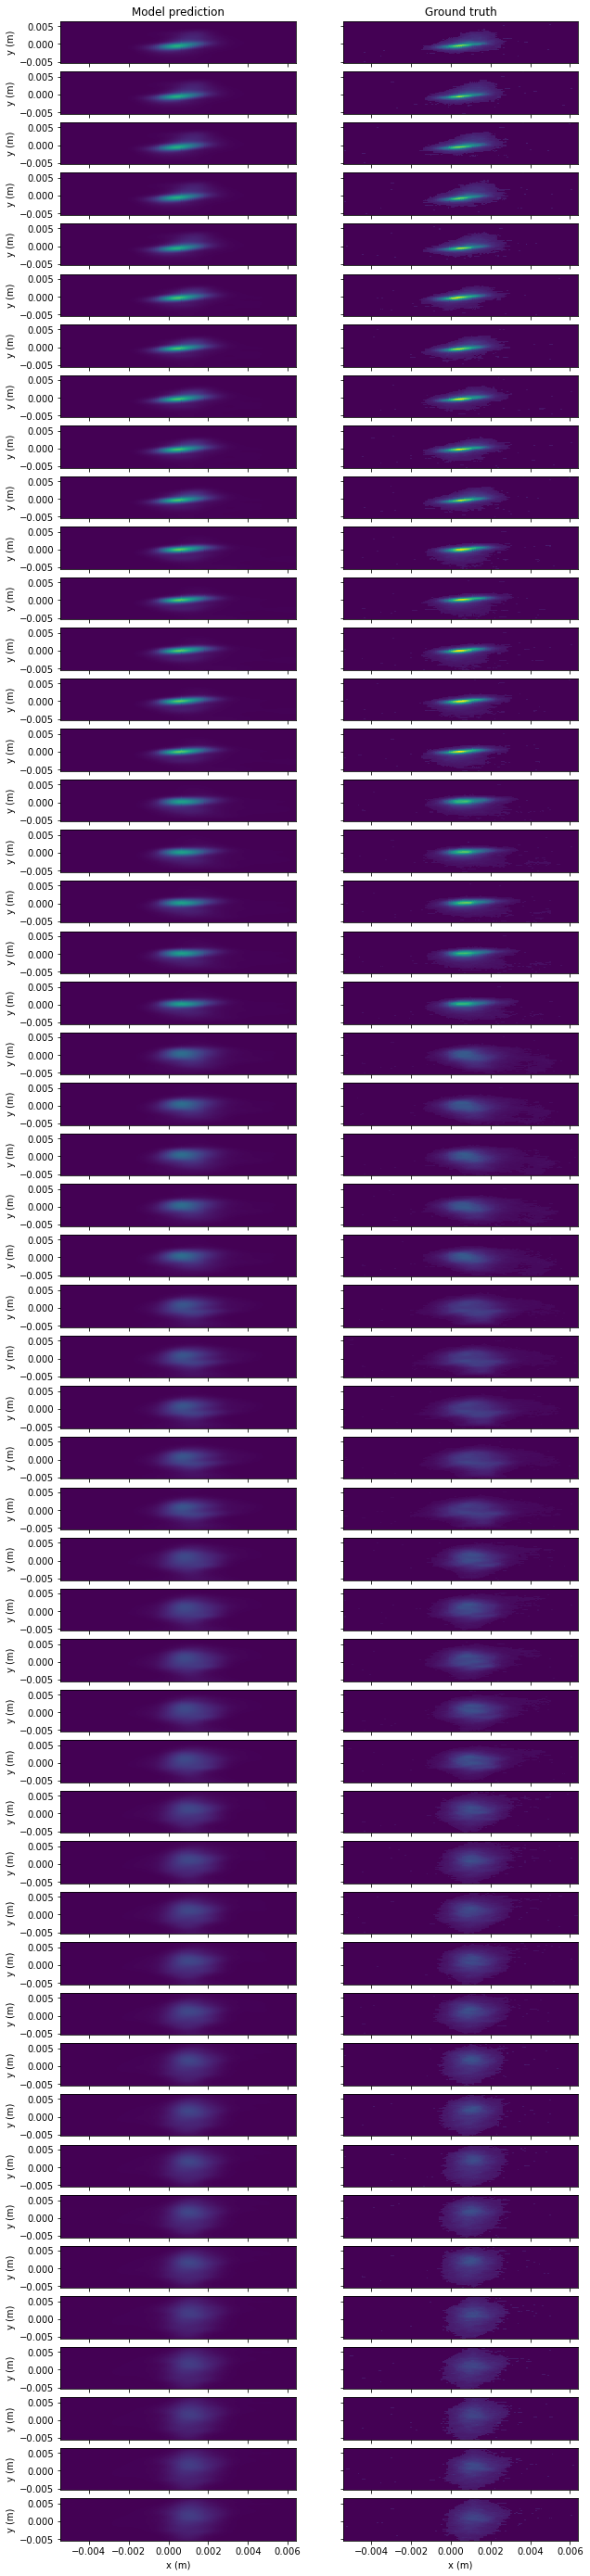

In [13]:
guess_dist = Particle(*tnf(normal_samples).T, **defaults)

loss = image_difference_loss(
    guess_dist, timages, lattice, bins=bins, bandwidth=bandwidth, plot_images=True,
    n_images=50
)
fig = plt.gcf()
fig.set_size_inches(10,50)
ax = fig.axes
ax[-2].set_xlabel("x (m)")
ax[-1].set_xlabel("x (m)")

ax[-2].set_ylabel("y (m)")
ax[-4].set_ylabel("y (m)")
ax[-6].set_ylabel("y (m)")
ax[-8].set_ylabel("y (m)")
ax[0].set_ylabel("y (m)")

fig.savefig("images.png")

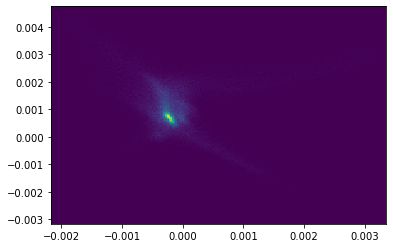

In [14]:
guess_dist = Particle(*tnf(normal_dist.sample([100000]).to(**tkwargs)).T.cpu().detach(), **defaults)
plt.hist2d(guess_dist.x.numpy(), guess_dist.px.numpy(),bins=200);

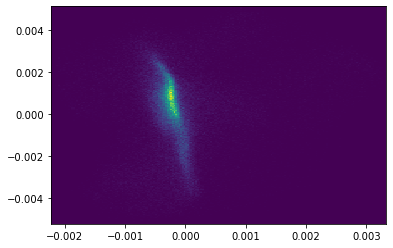

In [15]:
guess_dist = Particle(*tnf(normal_dist.sample([100000]).to(**tkwargs)).T.cpu().detach(), **defaults)
plt.hist2d(guess_dist.x.numpy(), guess_dist.y.numpy(),bins=200);

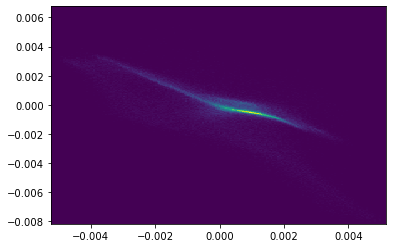

In [16]:
guess_dist = Particle(*tnf(normal_dist.sample([100000]).to(**tkwargs)).T.cpu().detach(), **defaults)
plt.hist2d(guess_dist.y.numpy(), guess_dist.py.numpy(),bins=200);